In [1]:
import torch

In [2]:
import pandas as pd

In [3]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [4]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [5]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings

In [7]:
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [8]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [9]:
import importlib
importlib.reload(myloadlib)

<module 'myloadlib' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myloadlib.py'>

In [10]:
documents = []

# Loading PDF

In [11]:
file = "./Rapport om Hussalg.pdf"

In [12]:
docs = loadFile(file)

In [13]:
documents.extend(docs)

In [14]:
len(documents)

2

In [15]:
documents[1].page_content[:300]

'Risiko for indbrud : \n[Indsæt kategorien for risiko for indbrud ] \nKontaktoplysninger  \nEjendomsmægler:  \n[Indsæt navn på ejendomsmægler]  \nTelefonnummer:  \n[Indsæt telefonnummer]  \nEmail:  \n[Indsæt emailadresse]  '

# Transforming text to prepare if for AI processing.

In [16]:
import myutils
from myutils import chunkDocs, langDetect, wordCloud 

In [17]:
importlib.reload(myutils)

<module 'myutils' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myutils.py'>

In [18]:
splits = myutils.chunkDocs(documents, 100)  
splits

[Document(page_content='Rapport om Hussalg  \nEjendomsoplysninger  \nAdresse:  \n[Indsæt adresse]  \nPostnummer og By:', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt postnummer og by]  \nBoligtype:  \n[Indsæt boligtype, fx villa, rækkehus, lejlighed]', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='Byggeår:  \n[Indsæt byggeår]  \nBoligareal:  \n[Indsæt boligareal i kvadratmeter]  \nAntal værelser:', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt antal værelser]  \nBeliggenhed  \nNærmeste Apotek : \n[Indsæt afstand  til nærmest e apote k]', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='Nærmeste Børnehave : \n[Indsæt afstand  til nærmest e apote k] \nNærmeste Indkøbsbutik :', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt afstand  til nærmest e apote k] \nØkonomiske Oplysnin

In [19]:
len(splits)

11

In [20]:
splits[8]

Document(page_content='Risiko for indbrud : \n[Indsæt kategorien for risiko for indbrud ] \nKontaktoplysninger', metadata={'source': './Rapport om Hussalg.pdf', 'page': 1})

In [21]:
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(5)

,page_content,metadata,type
8,"(page_content, Risiko for indbrud : \n[Indsæt ...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
6,"(page_content, Pris i Kvadratmeter: \n[Indsæt...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
7,"(page_content, [Indsæt ejendommens energimærke])","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
1,"(page_content, [Indsæt postnummer og by] \nBo...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
3,"(page_content, [Indsæt antal værelser] \nBeli...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"


In [22]:
df['page_content'][0]

('page_content',
 'Rapport om Hussalg  \nEjendomsoplysninger  \nAdresse:  \n[Indsæt adresse]  \nPostnummer og By:')

In [23]:
df['metadata'][0]

('metadata', {'source': './Rapport om Hussalg.pdf', 'page': 0})

In [24]:
im, longstring = myutils.wordCloud(df, 'page_content')

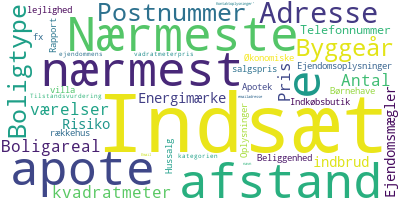

In [25]:
im

# Store documents in vector database

In [26]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [27]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
persist_directory = '../data/chroma/'

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [29]:
vectordb._collection.count()

61

In [30]:
query = 'Lav et dokument for et hus 1000 kroner værd'

In [31]:
answer = vectordb.similarity_search(query, k=3)
answer

[Document(page_content='[Indsæt oplysninger om indkøbsmuligheder i området]', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'}),
 Document(page_content='[Indsæt afstand  til nærmest e apote k] \nØkonomiske Oplysninger  \nPris:  \n[Indsæt salgspris]', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'}),
 Document(page_content='[Indsæt afstand  til nærmest e apote k] \nØkonomiske Oplysninger  \nPris:  \n[Indsæt salgspris]', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'})]

In [32]:
for d in answer:
    print(d.page_content)

[Indsæt oplysninger om indkøbsmuligheder i området]
[Indsæt afstand  til nærmest e apote k] 
Økonomiske Oplysninger  
Pris:  
[Indsæt salgspris]
[Indsæt afstand  til nærmest e apote k] 
Økonomiske Oplysninger  
Pris:  
[Indsæt salgspris]


In [33]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [34]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED    
mistral:latest	2ae6f6dd7a3d	4.1 GB	2 weeks ago	


In [35]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [36]:
# Skal bruge input fra GUI når den er klar i stedet for dette
house_info = {"adresse": "Nygårdsvej 41A. 2. tv", 
              "postnummer": "3460",
             "by": "Birkerød",
             "pris": 3895000,
             "type": "Ejerlejlighed",
             "antal_værelser": 3,
             "byggeår": 1969,
             "indbrud": "lav",
             "apotek": 480,
             "børnehave": 141,
             "indkøbsbutik": 78,
             "størrelse": 76,
             "kvadratmeterpris": 51250,
             "energimærke": "C",
             }
agent_info = {"navn": "Adam Sælger",
              "tlfnr": 33553355,
              "email": "as@gmail.com"
             }

In [37]:
def generate_template(house_info, agent_info):
    template = f"""Lav en rapport med disse oplysninger i samme format, men med overskrifter, der giver mening.
    Adressen: {house_info["adresse"]}
    Postnummer: {house_info["postnummer"]}
    By: {house_info["by"]}
    Pris: {house_info["pris"]} kroner
    Type: {house_info["type"]}
    Antal værelser: {house_info["antal_værelser"]}
    Byggeår: {house_info["byggeår"]}
    Risiko for indbrud: {house_info["indbrud"]} meter
    Afstand til apotek: {house_info["apotek"]} meter
    Afstand til børnehave: {house_info["børnehave"]} meter
    Afstand til indkøbsbutik: {house_info["indkøbsbutik"]} meter
    Størrelse: {house_info["størrelse"]} m^2
    Kvadratmeterpris: {house_info["kvadratmeterpris"]} kroner
    Energimærke: {house_info["energimærke"]}
    Ejendomsmægler oplysninger: {agent_info["navn"]}, 
    Telefonnummer: {agent_info["tlfnr"]}, 
    Email: {agent_info["email"]}
    """
    final_template = template + """{context}"""
    return final_template

In [38]:
prompt = PromptTemplate.from_template(generate_template(house_info, agent_info))
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [39]:
query = "Giv mig min fulde rapport"

In [40]:
result = chain({"query": query})
result["result"]

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


 **Rapport om Hussalg**
Ejendomsoplysninger
Adresse: Nygårdsvej 41A, 2. tv
Postnummer og By: 3460 Birkerød
Boligtype: Ejerlejlighed
Byggeår: 1969

**Rapport om Hussalg**
Ejendomsoplysninger
Adresse: [Indsæt adresse]
Postnummer og By: [Indsæt postnummer og by]
Boligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]
Byggeår:

**Rapport om Hussalg**
Ejendomsoplysninger
Adresse: [Indsæt adresse]
Postnummer og By: [Indsæt postnummer og by]
Boligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]
Byggeår:

**Bilag**
- [Tilstandsrapport]
- [Energimærke]
- [Plantegninger]

' **Rapport om Hussalg**\nEjendomsoplysninger\nAdresse: Nygårdsvej 41A, 2. tv\nPostnummer og By: 3460 Birkerød\nBoligtype: Ejerlejlighed\nByggeår: 1969\n\n**Rapport om Hussalg**\nEjendomsoplysninger\nAdresse: [Indsæt adresse]\nPostnummer og By: [Indsæt postnummer og by]\nBoligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]\nByggeår:\n\n**Rapport om Hussalg**\nEjendomsoplysninger\nAdresse: [Indsæt adresse]\nPostnummer og By: [Indsæt postnummer og by]\nBoligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]\nByggeår:\n\n**Bilag**\n- [Tilstandsrapport]\n- [Energimærke]\n- [Plantegninger]'

In [41]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def create_pdf(content, filename):
    c = canvas.Canvas(filename, pagesize=letter)
    textobject = c.beginText(100, 750)

    for line in content.split('\n'):
        textobject.textLine(line)

    c.drawText(textobject)
    c.save()

In [42]:
create_pdf(result["result"], "hus_report.pdf")